## 2017 rio k2 daws data - 3dB threshold check

### Function to read riometer file

##### linesplit [0] - date (dd/mm/yy)
##### linesplit [1] - time (UT)
##### linesplit [2] - absorption (dB)
##### linesplit [3] - raw signal (volts)

In [12]:
import datetime
import urllib.request

# define riometer readfile function
def rio_readfile(url):

    # Define lists
    date = [] #do i even need the date cause it's the same year?
    time = []
    absorption = []
    raw_sig = []

    # Define filename
    #filename = "RD 2012-03-03.txt"

    # open file to read
    response = urllib.request.urlopen(url)
    html_response = response.read()
    encoding = response.headers.get_content_charset("utf-8")
    fp = html_response.decode(encoding)

    # define new list sanitized_data
    # entry = [] list defined later, append datetime, absp, raw sig to it
    # later append entry to sanitized_data so it will be lists within a list
    sanitized_data = []
    
    for line in fp.splitlines():
        #print(line)
        #print(str(line))
    
        # skip comments
        if line[0] == "#":
            continue
        else:
            
            # strip line
            line_strip = line.strip()
            # split lines into lists
            line_split = line.split()
            #print(line_split[1])

            # Define datetime format for date and time
            
            format = "%d%m%Y%H:%M:%S"
            
            # split column 0 to month, date, year and make one row
            month = str(line_split[0].split("/")[1])
            day = str(line_split[0].split("/")[0])
            year = "20" + str(line_split[0].split("/")[2])
                      
            full_date = month + day + year + str(line_split[1])
            
            # Try-except to see if can convert to datetime
            try:
                res = bool(datetime.datetime.strptime(full_date, format))
                this_time = datetime.datetime.strptime(full_date, format)

                # Only append line to list if time checks true

                # append time to array
                time.append(this_time)
                # append absorption to array
                absorption.append(float(line_split[2]))
                # append raw signals to array
                raw_sig.append(line_split[3])

                # define new list 
                entry = []
                entry.append(this_time)
                entry.append(line_split[2])
                entry.append(line_split[3])
                
                sanitized_data.append(entry)
                    
            except ValueError:
                res = False

    #return sanitized_data
    return sanitized_data, time, absorption, raw_sig
    #return absorption
    #return raw_sig

### Function to check days with absorption > 3dB

In [18]:
# Define function high_abs to check days that have absp >3dB
def high_abs(data):
    
    counter = 0
    
    # threshold measurement: how many counts of 3dB absorption needed in a day to pass the check
    thresh_meas = 20
    
    # threshold absorption: minimum dB value to meet
    thresh_abs = 3
    
    # for every line in data, if there's a day with thresh_mesh at >= 20 of dB >= 3, then return 1
    for measurement in data:
        # try except error cause some absorption values are ****
        try:
            if float(measurement[1]) >= thresh_abs:
                counter += 1
        except:
            continue
        
        if counter > thresh_meas:
            return 1
    
    return 0

### 2017 3dB check

In [ ]:
from calendar import monthrange

# define base URL and base year
base = "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/GO-Rio/txt/"
year = "2017"

# check every month of the year
for month in range(1,13):
    
    # change month from example "4" to "04" for April (cause that's how it is in rio data)
    month_str = str(month).zfill(2)
    
    # go through every day of the month
    # with monthrange - auto day checker (like Jan 31 days, Feb 28 days etc.)
    for day in range(1, monthrange(int(year), month)[1] +1):
        # change day from example "9" to "09"
        day_str = str(day).zfill(2)
        
        # define new_base to replace year, month, and date with each url
        new_base = "https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/GO-Rio/txt/{year}/{month}/{day}/norstar_k2_rio-daws_{year}{month}{day}_v01.txt"
        
        # read the url, return sanitized_data list
        data = rio_readfile(new_base.format(year = year, month = month_str, day = day_str))
        
        # print/return 0 or 1 for each day of the year
        print (high_abs(data))

### Function to filter out spikes

In [23]:
import matplotlib.pyplot as plt
def filter_spikes(times, absorptions, threshold, year_str, month_str, day_str, datetime_format, neighbor_count=10):
    """
    Filter out absorption spikes where the value is greater than a threshold relative to the average of its neighbors.
    """
    filtered_times = []
    filtered_absorptions = []

    for i in range(len(absorptions)):
        # Determine the range for neighbors
        start_index = max(i - neighbor_count, 0)
        end_index = min(i + neighbor_count + 1, len(absorptions))

        # Calculate the average of neighboring values
        neighbor_avg = sum(absorptions[start_index:end_index]) / (end_index - start_index)

        # Check if the current value is within the threshold relative to the neighbor average
        if abs(absorptions[i] - neighbor_avg) <= threshold:
            filtered_times.append(times[i])
            filtered_absorptions.append(absorptions[i])
    
    def plot(filtered_times, filtered_absorptions):
        plt.plot(filtered_times, filtered_absorptions)
        plt.title("{year} {month_name} {day} Riometer absorption (dB) vs time (UTC {time}) with threshold {threshold}".format(year=year_str, month_name=month_str, day=day_str, time=datetime_format, threshold=threshold))
        plt.xlabel("Time (UTC) {time}".format(time=datetime_format), fontsize=10)
        plt.xticks(rotation=90)
        plt.ylabel("Absorption (dB)", fontsize=10)
       
    return plot(filtered_times, filtered_absorptions)

### 2017, Jan 2 - time vs absorption

Length of time list: 17279
Length of absp list: 17249


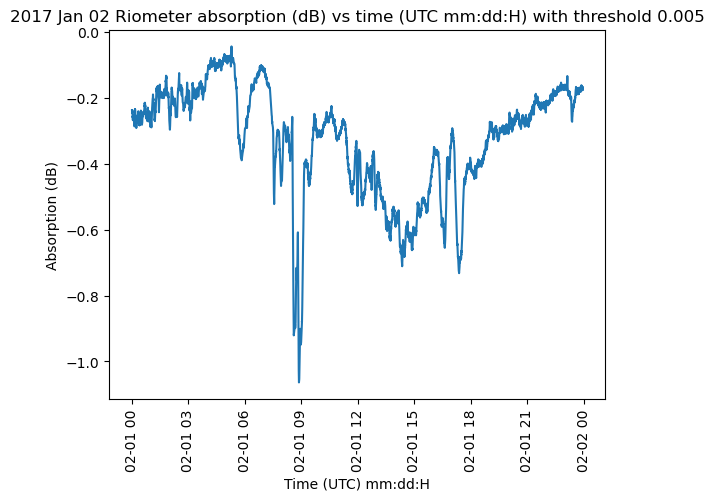

In [26]:
# 2017 jan 2

sanitized_data, time, absorption, raw_sig = rio_readfile("https://data.phys.ucalgary.ca/sort_by_project/GO-Canada/GO-Rio/txt/2017/01/02/norstar_k2_rio-daws_20170102_v01.txt")

threshold = 0.005
filter_spikes(time, absorption, threshold, "2017", "Jan", "02", "mm:dd:H", neighbor_count=10)
print("Length of time list:", len(time))
print("Length of absp list:", len(absorption))